##### modeling and interpretation notebook--train, test, and conclude
***

# Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Model Specific Libraries

In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import math

### Reopening our cleaned dataframe

In [3]:
pd.set_option('display.max_columns', 999)  # setting to view all columns

with open('data/data-drops.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_drops_df = pickle.load(f)

print("Dataframe successfully imported from pickle.\n\n")
display(data_drops_df.shape)
data_drops_df.head()

Dataframe successfully imported from pickle.




(19322, 16)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,0


# Questions

We have already found that some predictors could be eliminated, due to their lack of correlation or linearity with the response variable. We also eliminated some variables from our study, due to their collinearity with others.

We can begin investigating our remaining questions by building and testing a model, selecting and eliminating features, and adjusting variable coefficients along the way.

> As a reminder of our remaining basic questions:
1. ~~mean price~~
2. mean price within 20 miles of the city center
3. ~~mean bedrooms of home sales (roomates or rentals)~~
4. ~~which influences price more: the number of bedrooms or the number of square feet~~
5. do renovations make a significant difference in such a competitive market


We may have already answered question 5, but we will let the model decide for sure.

## Correlations
### Seeing where we stand

In [13]:
# creating a correlations table with absolute values
dd_corr = abs(data_drops_df.corr())

Tthe dataframe can be visually ordered to be more useful. We can order the columns by the strength of their correlation with price, so that is what we will do.

### Viewing columns sorted in order of correlation with `price`

In [14]:
# running a sorted correlation and grabbing indexes
dd_sort_ix = abs(
    dd_corr).sort_values(
    'price', ascending=False).index
dd_sortix = data_drops_df.loc[:, sort_ix]

### Viewing the sorted correlations table

In [15]:
# view without `id`
dds = dd_sortix.drop(['id'], axis=1).corr()

# view the correlations table
dds

,price,grade,sqft_living,bathrooms,lat,bedrooms,floors,Sqft_basement,view,Renovated,sqft_lot,condition,waterfront,long
price,1.000000,0.618932,0.609295,0.434373,0.413889,0.290800,0.270389,0.226851,0.200093,0.105261,0.070791,0.054149,0.024650,0.010399
grade,0.618932,1.000000,0.699486,0.613053,0.107739,0.335893,0.472663,0.057838,0.110132,0.000614,0.110850,-0.158711,0.010195,0.195652
sqft_living,0.609295,0.699486,1.000000,0.709376,0.033682,0.611205,0.366256,0.349491,0.129183,0.037033,0.202151,-0.060647,0.006378,0.250404
bathrooms,0.434373,0.613053,0.709376,1.000000,-0.000954,0.491025,0.520187,0.210283,0.071480,0.030984,0.036630,-0.130666,0.002532,0.230994
lat,0.413889,0.107739,0.033682,-0.000954,1.000000,-0.036622,0.037467,0.122920,0.015593,0.029110,-0.061206,-0.008453,-0.006727,-0.144036
bedrooms,0.290800,0.335893,0.611205,0.491025,-0.036622,1.000000,0.168740,0.272649,0.036044,0.010425,0.109847,0.028922,-0.009423,0.143168
floors,0.270389,0.472663,0.366256,0.520187,0.037467,0.168740,1.000000,-0.286285,-0.007517,-0.000451,-0.121772,-0.268026,0.000495,0.126038
Sqft_basement,0.226851,0.057838,0.349491,0.210283,0.122920,0.272649,-0.286285,1.000000,0.154804,0.049206,0.029763,0.184148,0.011890,-0.178279
view,0.200093,0.110132,0.129183,0.071480,0.015593,0.036044,-0.007517,0.154804,1.000000,0.038026,0.024076,0.035759,0.058646,-0.080293
Renovated,0.105261,0.000614,0.037033,0.030984,0.029110,0.010425,-0.000451,0.049206,0.038026,1.000000,0.006567,-0.055597,0.021866,-0.057528


It looks as though `grade` is most strongly correlated with price, followed by `sqft_living`. The weakest correlation to price is longitude, followed by `waterfront`. We can inspect this visually.

In [37]:
# create a function to generate a heatmap
def plot_corr_heatmap(cor, cmap="BuPu"):
    # creating a figure to plot a heatmap from correlations
    plt.figure(figsize=(21,18))
    sns.set(font_scale=1.5, color_codes=True) # making annotations legible
    # plotting
    sns.heatmap(cor.round(2).abs(), center=.8, annot=True, cmap="YlGnBu")
    plt.tick_params(axis="both", which="both", bottom=False, top=True,    
                labelbottom=False, labeltop=True,left=True, 
                    right=False, labelleft=True)
    plt.xticks(rotation = 70, fontsize=20)
    plt.yticks(fontsize=20)
    plt.autoscale() # prevent cropping
    plt.show()

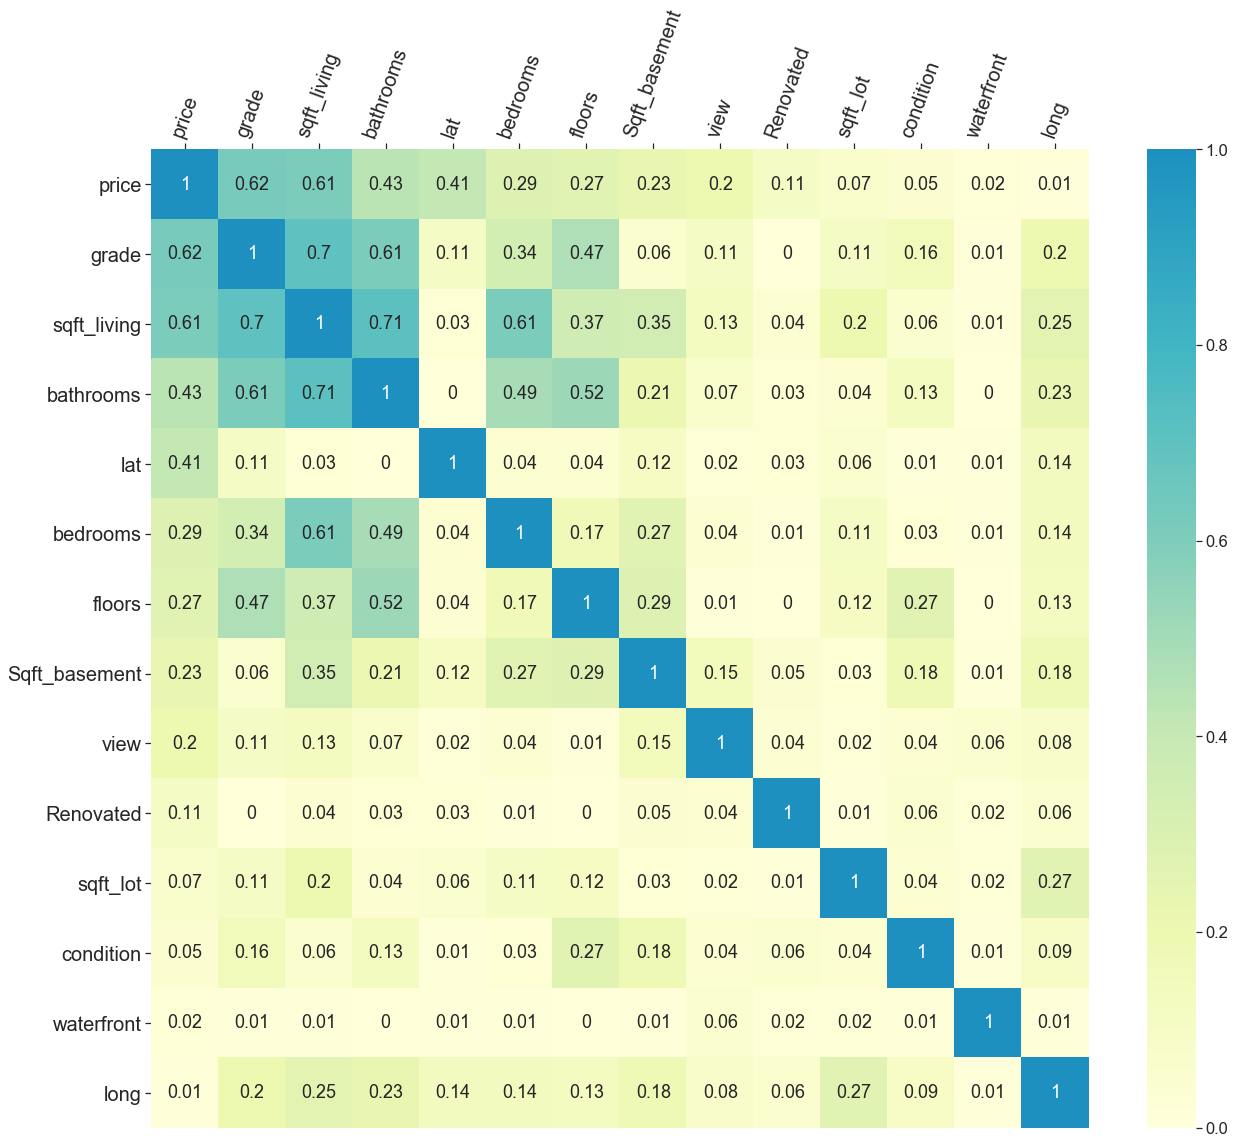

In [38]:
plot_corr_heatmap(dds)

This is a fairly clear indicator that `grade` and `sqft_living` are strong predictors. We also note, however, that the two appear to be strongly collinear. In addition, each appears to be strongly collinear with the next strongest feature, `bathrooms`.

In consideration of processing time, we can at this point eliminate a few weak predictors for price. At the risk of contradicting myself, and at the expense of my curiosity, I think it is fair to eliminate anything below 0.1: that comprises `long`, `waterfront`, `condition`, and `sqft_lot`.

### Dropping weak correlations

In [39]:
# removing the `long`, `waterfront`, `condition`, and `sqft_lot` columns
data_drops_df.drop(['long', 'waterfront', 'condition', 'sqft_lot'], axis=1, inplace=True)

data_drops_df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view',
       'grade', 'Sqft_basement', 'zipcode', 'lat', 'Renovated'],
      dtype='object')

Let's pickle our dataframe in its current state and move into modeling.

In [40]:
with open('data/dds-df.pickle', 'wb') as f:
    # Pickling the 'data_drops_df' dataframe using the highest protocol available.
    pickle.dump(data_drops_df, f, pickle.HIGHEST_PROTOCOL)

We will copy a new dataframe for modeling and testing.

In [42]:
# time to drop that `id` column
data_drops_df.drop('id', axis=1, inplace=True)

# creating `mod_df` as a copy of `data_drops_df`
mod_df = data_drops_df.copy()

# viewing first rows
mod_df.head(2)

,price,bedrooms,bathrooms,sqft_living,floors,view,grade,Sqft_basement,zipcode,lat,Renovated
0,221900.0,3,1.00,1180,1.0,0,7,0,98178,47.5112,0
1,538000.0,3,2.25,2570,2.0,0,7,400,98125,47.7210,1


### Raw Features Model

Let's get to those modeling and testing libraries.

We can set a baseline, with features as they are. Then we will make any transformations that appear promising and see whether they improve the model.

In [49]:
# instantiate an empty list
feats = []

# add the dataframe column names to the list without `price`
feats.extend(list(mod_df.columns)[1:])

# view the list of feature names
feats

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement',
 'zipcode',
 'lat',
 'Renovated']

Let's hold off on all the zip codes

In [51]:
# remove `zipcode` from the `feats` list
feats.pop(7)

'zipcode'

In [52]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = feats
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=mod_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3189.
Date:                Sat, 22 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:51:38   Log-Likelihood:            -2.5833e+05
No. Observations:               19322   AIC:                         5.167e+05
Df Residuals:                   19312   BIC:                         5.168e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.009e+07    3.9e+05    -77.106      0.000   -3.09e+07   -2.93e+07
bedrooms      -1.137e+04   1707.713     -6.660      0.000   -1.47e+04   -8026.825
bathrooms     -1.434e+04   2620.024     -5.474      0.000   -1.95e+04   -9207.677
sqft_living     135.6304      3.012     45.027      0.000     129.726     141.535
floors        -5330.3180   2839.828     -1.877      0.061   -1.09e+04     235.991
view           6.308e+04   2808.620     22.459      0.000    5.76e+04    6.86e+04
grade          8.023e+04   1709.571     46.929      0.000    7.69e+04    8.36e+04
Sqft_basement    13.2492      3.764      3.520      0.000       5.871      20.627
lat             6.26e+05   8231.777     76.051      0.000     6.1e+05    6.42e+05
Renovated      1.085e+05   6483.613     16.731      0.000    9.58e+04    1.21e+05
==============================================================================
Omnibus:                     8954.284   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91716.704
Skew:                           1.971   Prob(JB):                         0.00
Kurtosis:                      12.919   Cond. No.                     7.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The ols model's R-squared suggests that 59.8\% of the variance in `price` can be explained by our model. All p - values are low. Great!

But, wait. We have a skew of 1.971 and kurtosis measures 12.919, when skew should be near 0 and kurtosis should be around 3. This is an indication that our residuals are not nearly normal enough.

## Viewing residual distributions

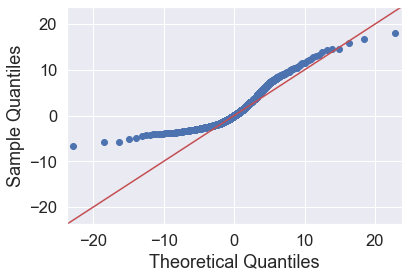

In [54]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

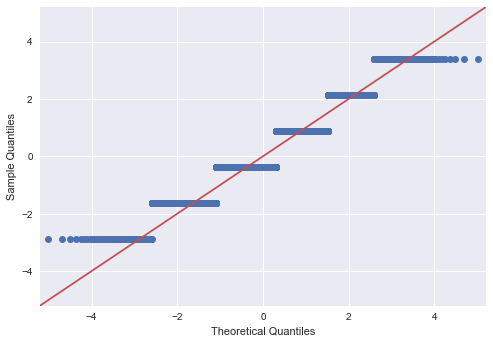

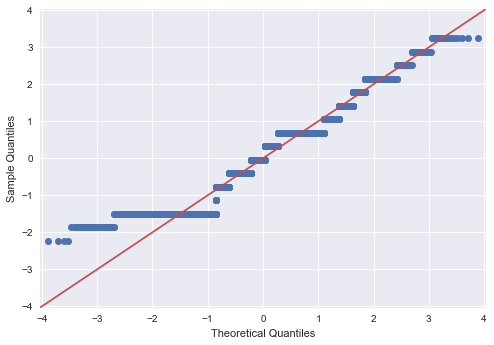

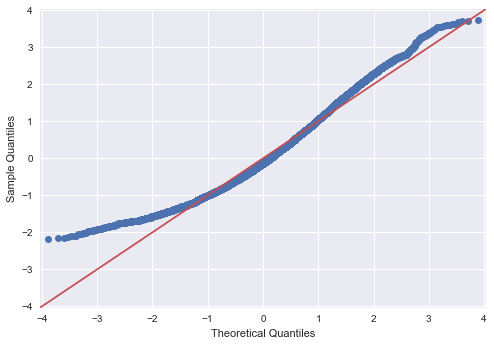

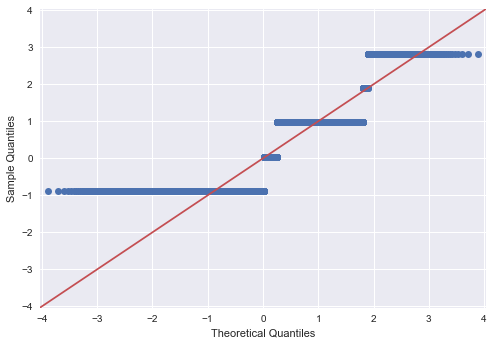

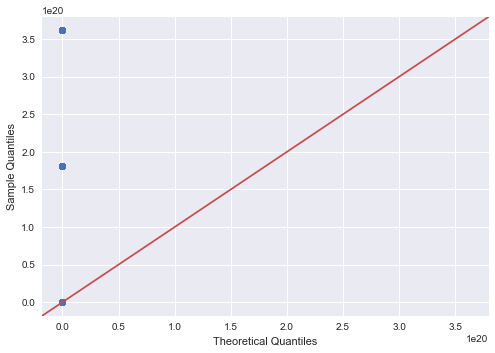

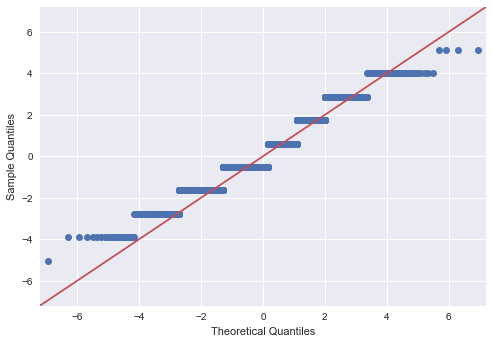

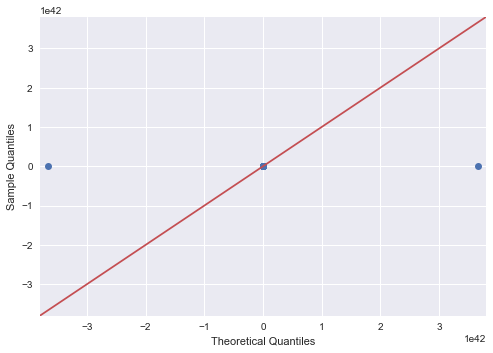

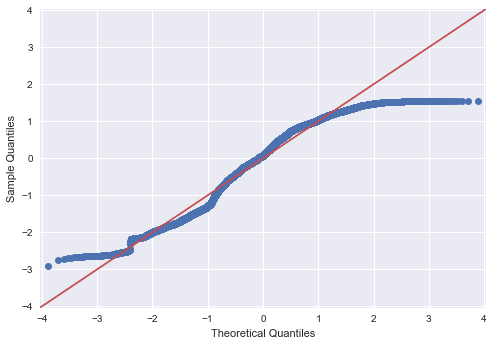

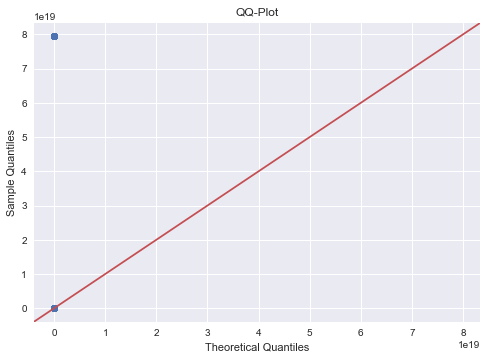

In [60]:
# qq-plotting select columns
for col in mod_df:
    if col in feats:
        sm.qqplot(mod_df[col], stats.t, fit=True, line='45')

plt.subplots_adjust(wspace=.35, hspace=1)
plt.title('QQ-Plot', va='bottom')
ylabel='test_this'
plt.show()

> Those definitely are not normal. What is going on, here?
* Some predictor variables, like 'bedrooms', are discrete.

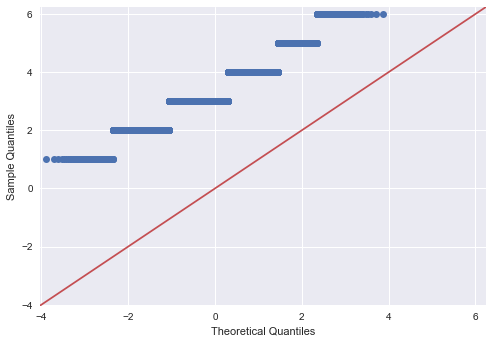

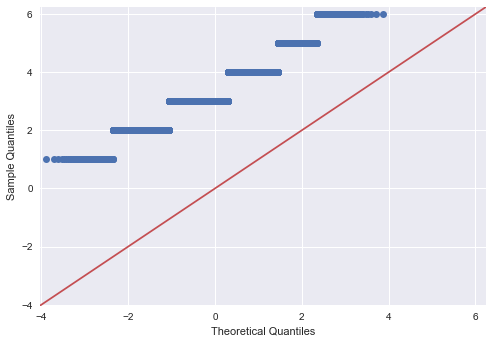

In [67]:
sm.qqplot(mod_df['bedrooms'], line='45')

Others, such as `sqft_living` are not quite normally distributed

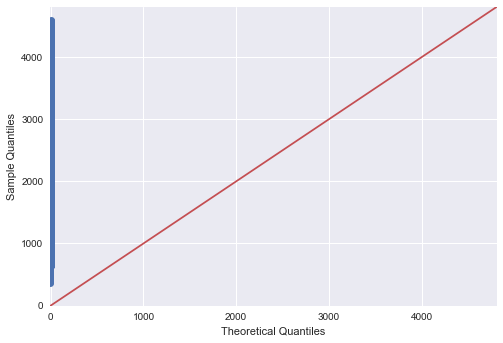

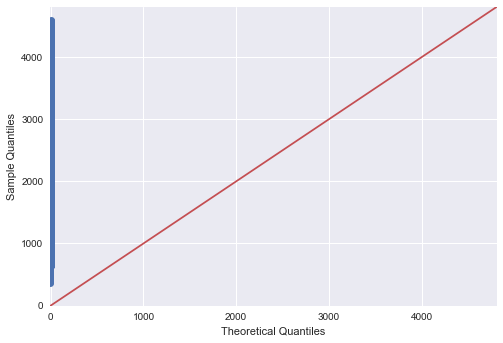

In [68]:
sm.qqplot(mod_df['sqft_living'], line='45')

* We need to log transform some of our features.
* We may need to use minmax scaling on some features to scale the data.

First, let's view our variables that are neither binary, log transform them, and check for improvement.

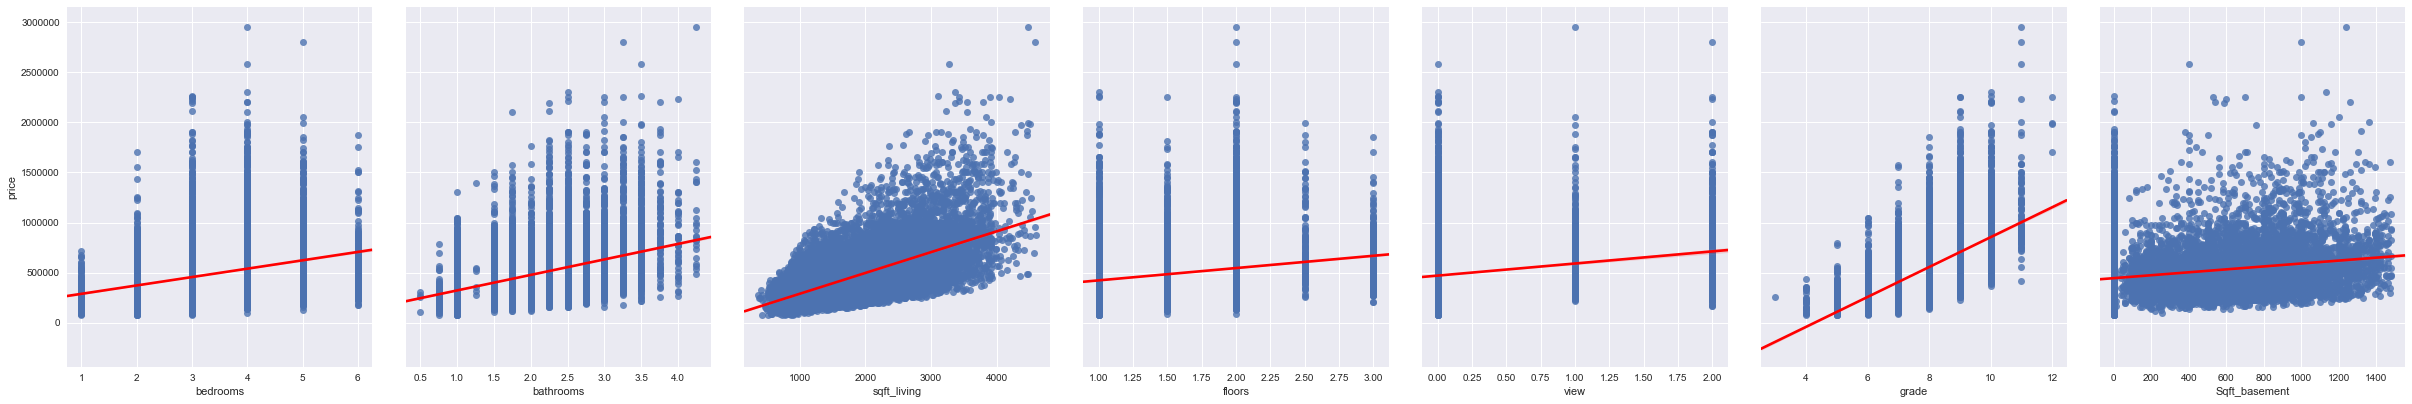

In [71]:
custom_palette = sns.color_palette("Dark2")

sns.pairplot(
    mod_df, x_vars=['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'view',
 'grade',
 'Sqft_basement'], y_vars='price',
    palette=custom_palette, height=6, aspect=.8, kind="reg",
    plot_kws={'line_kws': {'color': 'red'}}
)

In [ ]:
# viewing a pairplot for regression model columns
sns.pairplot(normal_df[x_cols], kind="reg", plot_kws={'line_kws':{'color':'orange'}})
sns.set(font_scale=.8) # try to prevent overlap of long column names
plt.subplots_adjust(wspace=.01, hspace=.1);
plt.show()

I think it only makes sense to focus on the `sqft` features for log transformation.

In [ ]:
# viewing a scatter matrix with log - transformed regression model columns

sns.pairplot(normal_df[x_cols], kind="reg", plot_kws={'line_kws':{'color':'orange'}})
sns.set(font_scale=.8) # try to prevent overlap of long column names
plt.subplots_adjust(wspace=.01, hspace=.1);
plt.show()

## OLS and Collinearity

In [ ]:
# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# viewing pairwise relationships
# sns.pairplot(data_f)

# plt.show()

The pairplots give a feel for just how much of the data is categorical.

### Q-Q Plot

Checking linearity with Q-Q Plots

In [ ]:
# import the required library
from statsmodels.graphics.gofplots import qqplot

## Jarque - Bera and Kurtosis
## Questions and Desired Variables
## Model & Testing
## Conclusion

### Review Assumptions for Linear Regression

- Linearity between target and predictor variables
    - Previewed above, but the scales may be a bit unbalanced, yet
- Normality of model residuals
    - Verify after building a baseline model
- Homoscedasticity: equal variability of a dependent variable across the values of an independent variable
    - Review after normalizing data
- Absence of, or minimal multicollinearity
    - We will need to select the best and discard the rest from multicollinear variables 

In [ ]:
# custom_palette = sns.color_palette("Dark2")
# sns.pairplot(no_hots_df, x_vars=["bedrooms", "sqft_basement"], y_vars=["price"],
#              hue="waterfront", palette=custom_palette, height=5, aspect=.8, kind="reg");

## Pickle the model / current - state dataframe

Store the `*****` dataframe in a sub - directory of the repository as `****************`.

In [ ]:
# with open('data/*****.pickle', 'wb') as f:
#     # Pickling the '******' dataframe using the highest protocol available.
#     pickle.dump(******, f, pickle.HIGHEST_PROTOCOL)

## Questions Asked

## Questions Answered

## Next

* 

# Notes
***

In [ ]:
# import gc
# gc.get_count()
# gc.collect()
# gc.get_count()

## Dealing with Outliers

In [ ]:
# from scipy import stats

### Taking a look at how far out our outliers are

In [ ]:
# creating a function to identify columns in a dataframe
# with values more than 3 standard deviations from the mean
# def check_outliers(df, col):
#     std_min = df[col].mean() - 3*df[col].std()
#     std_max = df[col].mean() + 3*df[col].std()
#     if df[col].min() < std_min or df[col].max() > std_max:
#         print(f"\nValue in {col} exceeds +/- 3 standard deviations")
#         print(f"column max: {df[col].max()}, std.dev. max: {std_max}")
#         print(f"column mini: {df[col].min()}, std.dev. min: {std_min}")
#         print("-"*72)

# parking lot:

> 

In [ ]:
# no_hots_df.sqft_above.hist(alpha=.6, color='red')
# sqs.sqft_above.hist(alpha=.6, color='green')
# sqs_3000.sqft_above.hist(alpha=.6, color='blue')

# plt.show()

In [ ]:
# no_hots_df.sqft_lot.apply(np.log).hist(alpha=.5)
# no_hots_df.sqft_lot15.apply(np.log).hist(alpha=.3)
# plt.show()

In [ ]:

# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# scatter plot a map
# df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
# plt.savefig('map1.png')

In [ ]:
# color scatter plot map from least-to-most expensive
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
    c="lastsoldprice", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)